# **Autoencoder Presentación Intermedia**

# Librerías requeridas


In [ ]:
# Si está en local, deberá tener instaladas todas las librerías necesarias.
!pip install umap-learn
!pip install umap-learn[plot]


In [2]:
#Librerias visualizacion de datos.
import sys
import time
from os import path
from collections import Counter

import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import umap
import umap.plot

# Datos

In [9]:
# Están los datos en local o drive?
path_stamp_dataset_21_new = None
# path_stamp_dataset_21_new = 'E:Datos ZTF\stamp_dataset_21_new.pkl'

if path_stamp_dataset_21_new == None: # Sólo aplica si el path de drive coincide

    drive.mount('/content/drive') #Montaje de Google Drive
    path_stamp_dataset_21_new = '/content/drive/MyDrive/Proyecto Inteligencia/Datos ZTF/stamp_dataset_21_new.pkl'

Mounted at /content/drive


In [10]:
# Función para cargar archivos .pkl
def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [11]:
#Cargar datasets
datos_stamp_dataset_21_new = cargar_datos(path_stamp_dataset_21_new)

# **Autoencoder**

# Carga de datos

In [12]:
def print_keys(data, indent=0):
    for key, value in data.items():
        print(' ' * indent + str(key))
        if isinstance(value, dict):
            print_keys(value, indent + 2)
        elif isinstance(value, (list, tuple)):
            print(' ' * (indent + 2) + f'List/Tuple of length {len(value)}')
        elif hasattr(value, 'shape'):
            print(' ' * (indent + 2) + f'Shape: {value.shape}')
        else:
            print(' ' * (indent + 2) + str(type(value)))

print_keys(datos_stamp_dataset_21_new)

class StampDataset(Dataset):
    def __init__(self, data, split,transform=False):
        self.transform = transform
        self.images = data[split]['images']
        self.features = data[split]['features']
        self.label = data[split]['class']
        self.split = split

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        images = self.images[idx]
        # Normalizar
        if self.transform:
            images = (images-mean)/std
        return self.images[idx], self.features[idx], self.label[idx]

train_dataset = StampDataset(datos_stamp_dataset_21_new, 'Train')

val_dataset = StampDataset(datos_stamp_dataset_21_new, 'Validation')

Train
  images
    Shape: (72710, 21, 21, 3)
  features
    Shape: (72710, 26)
  oid
    Shape: (50594,)
  class
    Shape: (72710,)
Test
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)
Validation
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)


# Autoencoder


In [13]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class ConvAutoencoder(nn.Module):
    def __init__(self,
        dropout_p,
        ):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1),  # 21x21,3 -> 18x18,32
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 18x18,32 -> 18x18,32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 18x18,32 -> 9x9,32
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 9x9,32 -> 9x9,64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 9x9,64 -> 9x9,64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 9x9,64 -> 4x4,64
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 4x4,64 -> 4x4,64
            nn.ReLU(),
            nn.Flatten(),  # 4x4x64 -> 1024
            nn.Linear(1024, 64),  # 1024 -> 64
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 1024),  # 64 -> 1024
            Reshape(-1, 64, 4, 4),  # Reshape 64 canales, 4x4
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4,64 -> 9x9,64
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9,64 -> 18x18,32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 18x18,32 -> 18x18,16
            nn.ReLU(),
            nn.Upsample(size=(21, 21), mode='bilinear', align_corners=True),  # Upsample: 18x18,16 -> 21x21,16
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # 21x21x16 -> 21x21x3
            #nn.Sigmoid()  # Final output between 0 and 1
        )
        # Clasificador MLP
        self.mlp = nn.Sequential(
            nn.Linear(64, 128),  # El embedding de 64 dimensiones
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(128, 5)
        )

    def forward(self, x):
        # Paso por el encoder
        emb = self.encoder(x)
        recon = self.decoder(emb)

        clasif = self.mlp(emb)

        return recon, clasif

# Visualizacion y confirmacion de inputs y outputs

In [14]:
def show_shapes(model, input_tensor):
    x = input_tensor
    print(f"Input shape: {x.shape}")

    # Show shapes in the encoder
    for layer in model.encoder:
        x = layer(x)
        print(f"After {layer.__class__.__name__}, shape: {x.shape}")

    # Show the encoder output shape
    print(f"Encoder output shape: {x.shape}")

    # Show shapes in the decoder
    for layer in model.decoder:
        x = layer(x)
        print(f"After {layer.__class__.__name__}, shape: {x.shape}")

    # Final output shape
    print(f"Final output shape: {x.shape}")

# Create the dummy input
dummy_input = torch.randn(1, 3, 21, 21)  # 21x21 input with 3 channels

# Instantiate the model
model = ConvAutoencoder(dropout_p=0.5)

# Show shapes for each layer
show_shapes(model, dummy_input)


Input shape: torch.Size([1, 3, 21, 21])
After Conv2d, shape: torch.Size([1, 32, 18, 18])
After ReLU, shape: torch.Size([1, 32, 18, 18])
After Conv2d, shape: torch.Size([1, 32, 18, 18])
After ReLU, shape: torch.Size([1, 32, 18, 18])
After MaxPool2d, shape: torch.Size([1, 32, 9, 9])
After Conv2d, shape: torch.Size([1, 64, 9, 9])
After ReLU, shape: torch.Size([1, 64, 9, 9])
After Conv2d, shape: torch.Size([1, 64, 9, 9])
After ReLU, shape: torch.Size([1, 64, 9, 9])
After MaxPool2d, shape: torch.Size([1, 64, 4, 4])
After Conv2d, shape: torch.Size([1, 64, 4, 4])
After ReLU, shape: torch.Size([1, 64, 4, 4])
After Flatten, shape: torch.Size([1, 1024])
After Linear, shape: torch.Size([1, 64])
After ReLU, shape: torch.Size([1, 64])
Encoder output shape: torch.Size([1, 64])
After Linear, shape: torch.Size([1, 1024])
After Reshape, shape: torch.Size([1, 64, 4, 4])
After ConvTranspose2d, shape: torch.Size([1, 64, 8, 8])
After ReLU, shape: torch.Size([1, 64, 8, 8])
After ConvTranspose2d, shape: torc

## Entrenamiento

In [15]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

In [16]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    x_batch = x_batch.float().permute(0, 3, 1, 2)
    _, y_predicted = model(x_batch)
    y_batch = y_batch.long()

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    # Para recolectar todas las predicciones y etiquetas verdaderas
    x_preds = []
    x_labels = []

    for x_val, _, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        x_val = x_val.float().permute(0, 3, 1, 2)
        y_val = y_val.long()
        _, y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        # Guardar las predicciones y las etiquetas verdaderas
        x_preds.extend(class_prediction.cpu().numpy())
        x_labels.extend(y_val.cpu().numpy())

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss, x_labels, x_preds

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Generar la matriz de confusión
    cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Graficar la matriz de confusión
    fig, ax = plt.subplots(figsize=(7, 7))
    disp.plot(ax=ax, cmap='Blues', values_format=".2f")
    plt.title("Test set")
    plt.show()

def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=True,
    data_augmentation=True,
    early_stopping_tolerance=5,
):


    if use_gpu:
        model.cuda()

    early_stopping = EarlyStopping(n_epochs_tolerance=early_stopping_tolerance)

    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    for epoch in range(epochs):
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for param in model.encoder.parameters():
            param.requires_grad = False
        i = 0
        for i, (img, _, labels) in enumerate(train_loader):
            if use_gpu:
                img = img.cuda()
                labels = labels.cuda()

            y_predicted, loss = train_step(img, labels, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += labels.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (labels == class_prediction).sum().item()

            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss, all_labels, all_preds = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        if early_stopping(val_loss):
            print("Early stopping.")
            break

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()


    return curves

In [17]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

Epoch 1/50
Iteration 189 - Batch 189/1137 - Train loss: 1.61043980247096, Train acc: 0.19547697368421052
Iteration 378 - Batch 378/1137 - Train loss: 1.6099879030816473, Train acc: 0.20028034300791556
Iteration 567 - Batch 567/1137 - Train loss: 1.609809429922574, Train acc: 0.20320752640845072
Iteration 756 - Batch 756/1137 - Train loss: 1.6097563661073915, Train acc: 0.20283603038309114
Iteration 945 - Batch 945/1137 - Train loss: 1.6097089901535002, Train acc: 0.20439680232558138
Iteration 1134 - Batch 1134/1137 - Train loss: 1.6096481296984635, Train acc: 0.20430892070484583
Val loss: 1.6087490320205688, Val acc: 0.2
Epoch 2/50
Iteration 1326 - Batch 189/1137 - Train loss: 1.608940883686668, Train acc: 0.2114309210526316
Iteration 1515 - Batch 378/1137 - Train loss: 1.6087029562147437, Train acc: 0.21351418205804748
Iteration 1704 - Batch 567/1137 - Train loss: 1.60867262012522, Train acc: 0.21157020246478872
Iteration 1893 - Batch 756/1137 - Train loss: 1.608528693884493, Train ac

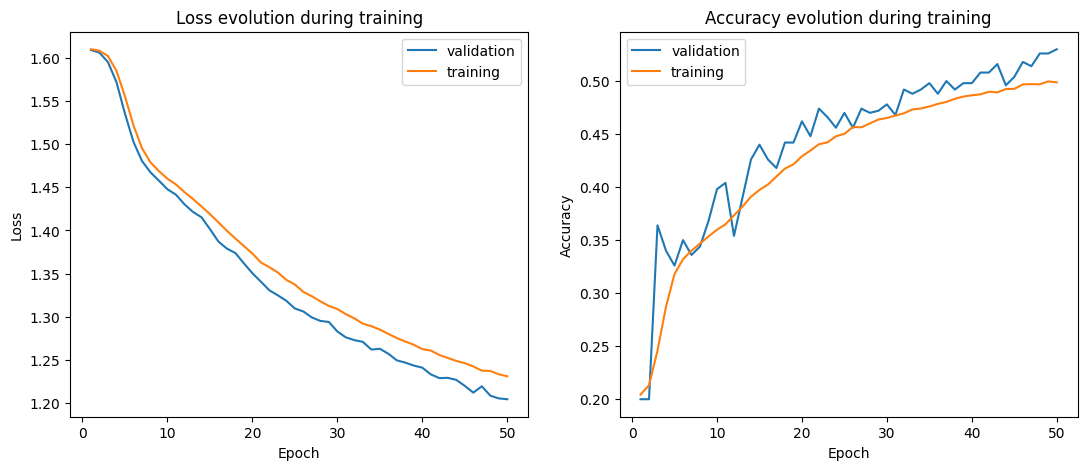

In [ ]:
lr = 1e-3
dropout_p = 0.5
batch_size = 64
criterion = nn.CrossEntropyLoss()

epochs = 50
model = ConvAutoencoder(dropout_p=dropout_p)

curves = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True,
    data_augmentation=False,
)

show_curves(curves)

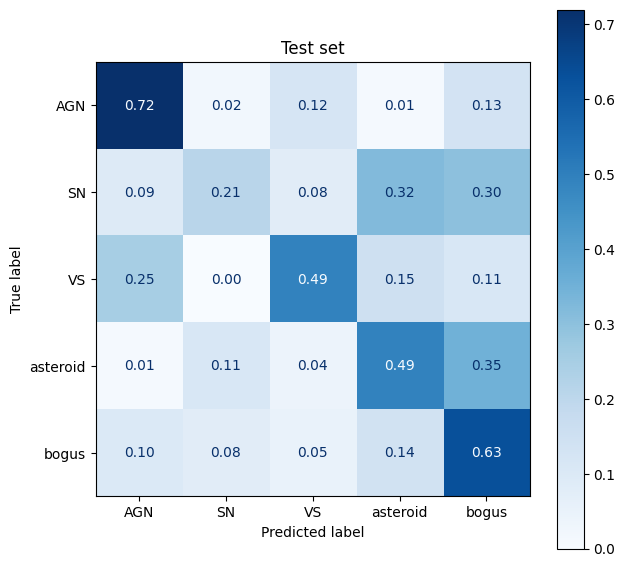

Test Set Accuracy 0.508
Test Set Loss 1.1961286067962646


In [ ]:
# Graficar la matriz de confusión de test
test_dataset = StampDataset(datos_stamp_dataset_21_new, 'Test')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, pin_memory=True)


with torch.no_grad():
        test_acc, test_loss, test_labels, test_preds = evaluate(test_loader, model, criterion, use_gpu=False)


plot_confusion_matrix(test_labels, test_preds, class_names=["AGN", "SN", "VS", "asteroid", "bogus"])

print("Test Set Accuracy", test_acc)
print("Test Set Loss", test_loss)

# Umap


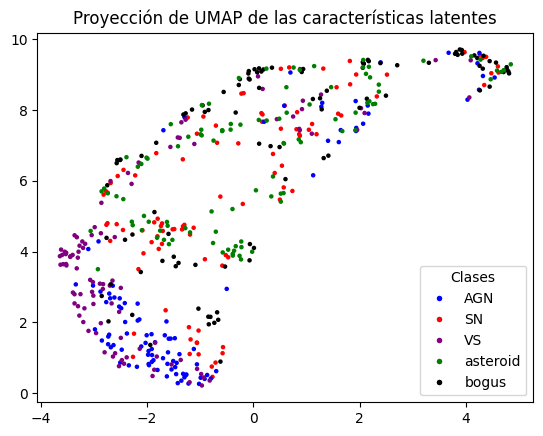

In [ ]:
# Si estás usando una GPU, mueve el modelo a CUDA
if torch.cuda.is_available():
    model = model.cuda()

# Si el modelo ya está entrenado, puedes cargar los pesos aquí, por ejemplo:
# autoencoder.load_state_dict(torch.load('ruta_al_modelo_entrenado.pth'))

# Función para extraer las características latentes utilizando la parte codificadora del autoencoder
def extract_latent_features(model, data_loader):
    model.eval()  # Asegúrate de que el modelo está en modo evaluación
    latent_features = []
    labels = []

    with torch.no_grad():  # No se necesitan gradientes
        for data in data_loader:
            inputs, _, label = data  # Asumiendo que la segunda columna no se usa
            if torch.cuda.is_available():
                inputs = inputs.cuda()

            # Pasamos las imágenes a través del codificador (self.encoder)
            latent = model.encoder(inputs.float().permute(0, 3, 1, 2))

            # Guardamos los embeddings latentes y las etiquetas
            latent_features.append(latent.cpu().numpy())
            labels.append(label.cpu().numpy())

    # Convertir las listas a arrays para trabajar con ellas
    return np.concatenate(latent_features), np.concatenate(labels)

# Mapeo de etiquetas a nombres de clases
class_mapping = {
    0: 'AGN',        # Clase 0
    1: 'SN',         # Clase 1
    2: 'VS',         # Clase 2
    3: 'asteroid',   # Clase 3
    4: 'bogus'       # Clase 4
}

# Función para convertir las etiquetas numéricas a etiquetas de clase
def map_labels_to_class_names(labels, class_mapping):
    return np.vectorize(class_mapping.get)(labels)

# Supongamos que tienes un modelo autoencoder entrenado llamado 'autoencoder'
# y un test_loader que contiene los datos de prueba
# Extraemos las características latentes del conjunto de prueba
latent_test, test_labels = extract_latent_features(model, test_loader)

# Convertimos las etiquetas numéricas en nombres de clase
test_labels_mapped = map_labels_to_class_names(test_labels, class_mapping)

# Paso 2: Aplicar UMAP para reducir la dimensionalidad de las características latentes
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.1)
embedding = umap_model.fit_transform(latent_test)

# Colores personalizados para cada clase
class_colors = {
    'AGN': 'blue',
    'SN': 'red',
    'VS': 'purple',  # Cambiamos el color de 'VS' de amarillo a púrpura
    'asteroid': 'green',
    'bogus': 'black'
}

# Obtener los colores según la clase
colors = [class_colors[class_mapping[label]] for label in test_labels]

# Paso 3: Visualizar las características embebidas con UMAP
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=5)

# Asignamos nombres de clase al colorbar
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', label=class_name,
                          markerfacecolor=color, markersize=5)
                   for class_name, color in class_colors.items()]

plt.legend(handles=legend_elements, title="Clases")
plt.title('Proyección de UMAP de las características latentes')
plt.show()

